In [8]:
import psycopg2
import pandas as pd

conn_str = "host=localhost user=postgres dbname=ttc"
conn = psycopg2.connect(conn_str)

df = pd.read_sql("select a.requestid, a.timint, (a.timint - COALESCE(b.timint, 0)) as timediff from ntas_data as a inner join ntas_data as b on a.id = b.id+1 and a.station_char = b.station_char and a.train_message in ('Arriving', 'Delayed') and b.train_message = 'AtStation' limit 100000;", conn)
df.head()

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


,requestid,timint,timediff
0,270,10.185101,10.185101
1,226,7.395238,7.395238
2,223,3.860849,3.860849
3,221,5.661169,5.661169
4,212,1.626036,1.626036


So we have a truncated dataset. The dataset is limited to 10k entries, as the number of possible entries is ~35MM. Regardless, this will serve as a nice proof of concept, and we'll plot a histogram of it.

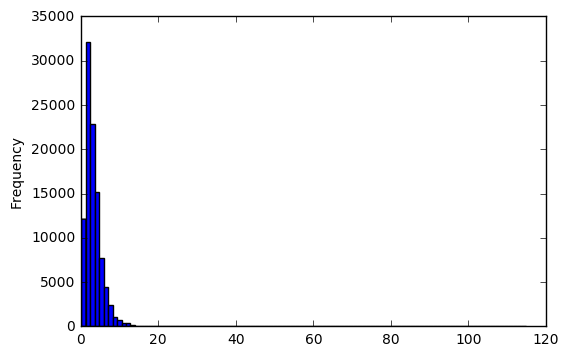

In [9]:
import matplotlib.pyplot as plt
df['timediff'].plot.hist(bins=100)
plt.show()

Now we will want to normalize the dataframe to the time difference. For more accuracy, we should grab data from request times, and figure out the time difference there, but we want to use this as a proof of concept first. We will subtract 1 to just normalize, because that's more or less the time difference. First, let's look at the dataset.

In [10]:
df.describe()

,requestid,timint,timediff
count,100000.000000,100000.000000,100000.000000
mean,118968.807520,3.325718,3.325718
std,66945.340535,2.806300,2.806300
min,206.000000,0.174171,0.174171
25%,58098.750000,1.796907,1.796907
50%,130164.000000,2.701581,2.701581
75%,173903.000000,4.097050,4.097050
max,230123.000000,114.850683,114.850683


We're only going to look at data within the 20 minute mark.

In [12]:
df = df.loc[df['timint'] < 20]
df.describe()

,requestid,timint,timediff
count,99749.000000,99749.000000,99749.000000
mean,119001.543675,3.243845,3.243845
std,66959.801306,2.091455,2.091455
min,206.000000,0.174171,0.174171
25%,58079.000000,1.792503,1.792503
50%,130299.000000,2.694400,2.694400
75%,173948.000000,4.078724,4.078724
max,230123.000000,19.999108,19.999108


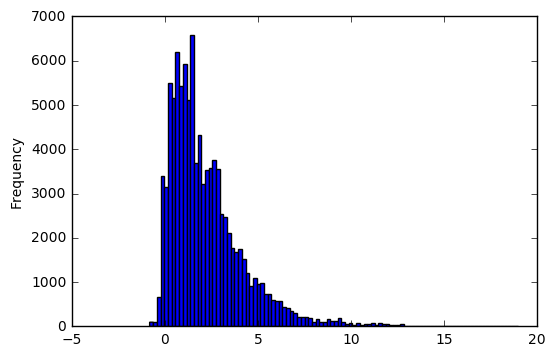

In [13]:
normalized_timediff = df['timediff'].apply(lambda x: x - 1)
normalized_timediff.plot.hist(bins=100)
plt.show()

So the distribution roughly shows that a significant portion of the time the estimation does end up being longer than a minute. Let's see the proportion of times that the estimate is less than the time advertised.

In [14]:
beat_expectations = normalized_timediff[normalized_timediff <= 0]
disappointments = normalized_timediff[normalized_timediff > 0]
len(beat_expectations) / len(disappointments) * 100

5.642812509928935

So, we beat estimates roughly 5.6% of the time. That...sucks.

TODO: What should we investigate?
- specific stations: what if the ends are skewing our results a little bit
- look at delayed status: what threshold do they start notifications?
- should adjust query to make sure it's the same train + direction that we're tracking...
- 